In [52]:
import opendatasets as od
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score

if not os.path.exists("../datasets"):
    os.makedirs("../datasets")

PROJECT_URL = "https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset"
PROJECT_NAME = PROJECT_URL.split("/")[-1]
DATA_PATH = os.path.join("../datasets", PROJECT_NAME)
od.download(PROJECT_URL, "../datasets")

Skipping, found downloaded files in "../datasets/usa-real-estate-dataset" (use force=True to force download)


In [53]:
df = pd.read_csv(os.path.join(DATA_PATH, "realtor-data.csv"))
df.head()

,status,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date,price
0,for_sale,3.0,2.0,0.12,Adjuntas,Puerto Rico,601.0,920.0,NaN,105000.0
1,for_sale,4.0,2.0,0.08,Adjuntas,Puerto Rico,601.0,1527.0,NaN,80000.0
2,for_sale,2.0,1.0,0.15,Juana Diaz,Puerto Rico,795.0,748.0,NaN,67000.0
3,for_sale,4.0,2.0,0.10,Ponce,Puerto Rico,731.0,1800.0,NaN,145000.0
4,for_sale,6.0,2.0,0.05,Mayaguez,Puerto Rico,680.0,NaN,NaN,65000.0


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          100000 non-null  object 
 1   bed             75050 non-null   float64
 2   bath            75112 non-null   float64
 3   acre_lot        85987 non-null   float64
 4   city            99948 non-null   object 
 5   state           100000 non-null  object 
 6   zip_code        99805 non-null   float64
 7   house_size      75082 non-null   float64
 8   prev_sold_date  28745 non-null   object 
 9   price           100000 non-null  float64
dtypes: float64(6), object(4)
memory usage: 7.6+ MB


In [55]:
df.describe()

,bed,bath,acre_lot,zip_code,house_size,price
count,75050.000000,75112.000000,85987.000000,99805.000000,7.508200e+04,1.000000e+05
mean,3.701013,2.494595,13.613473,2132.003467,2.180082e+03,4.383656e+05
std,2.091372,1.573324,840.143878,2455.654774,5.625349e+03,1.015773e+06
min,1.000000,1.000000,0.000000,601.000000,1.000000e+02,4.450000e+02
25%,3.000000,2.000000,0.190000,971.000000,1.200000e+03,1.250000e+05
50%,3.000000,2.000000,0.510000,1225.000000,1.728000e+03,2.650000e+05
75%,4.000000,3.000000,2.000000,1611.000000,2.582000e+03,4.749000e+05
max,86.000000,56.000000,100000.000000,99999.000000,1.450112e+06,6.000000e+07


In [56]:
df.describe(include='O').T

,count,unique,top,freq
status,100000,2,for_sale,99819
city,99948,525,San Juan,4788
state,100000,12,Massachusetts,52694
prev_sold_date,28745,3604,2019-10-01,83


In [57]:
df.isnull().sum()

status                0
bed               24950
bath              24888
acre_lot          14013
city                 52
state                 0
zip_code            195
house_size        24918
prev_sold_date    71255
price                 0
dtype: int64

In [58]:
# Status seems irrelevant , prev_sold_date 71% missing values
df.drop(columns=["status", "prev_sold_date", "zip_code"], inplace=True)

In [59]:
print(df.state.value_counts())

state
Massachusetts     52694
Puerto Rico       24679
Connecticut       12178
Virgin Islands     2573
Rhode Island       2401
New Hampshire      2232
New York           1874
Vermont            1324
South Carolina       24
Tennessee            16
Virginia              3
New Jersey            2
Name: count, dtype: int64


In [60]:
# Drop states with low sample size
print(df.shape)
df = df.loc[~df.state.isin(["South Carolina", "Tennessee", "Virginia", "New Jersey"]), :]
print(df.shape)

(100000, 7)
(99955, 7)


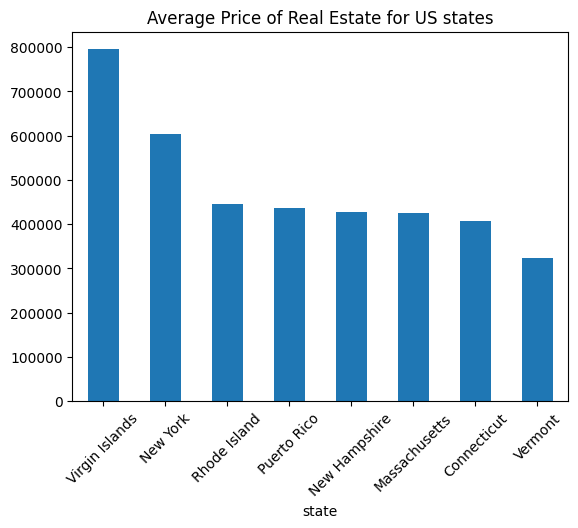

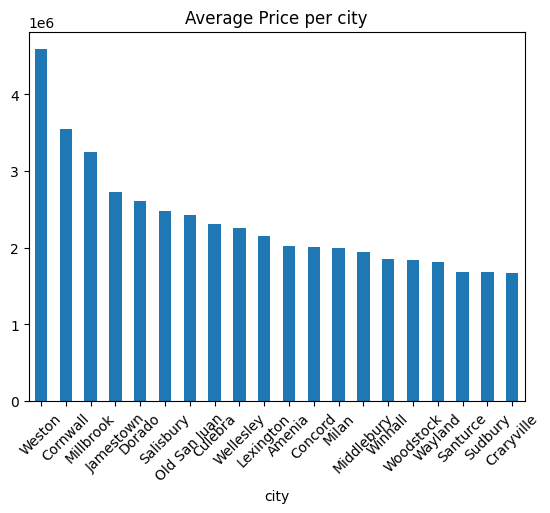

In [61]:
df.groupby('state').price.mean().sort_values(ascending=False).plot.bar()
plt.title('Average Price of Real Estate for US states')
plt.xticks(rotation=45)
plt.show()
df.groupby('city').price.mean().sort_values(ascending=False).head(20).plot.bar()
plt.title('Average Price per city')
plt.xticks(rotation=45)
plt.show()

In [62]:
# Drop rows that have at least one null value
df_dropna_all = df.dropna()

From the output of <b>.describe()</b> we see that we have outliars. I will remove them using the rule anything outside the interval <b>[Q1 - interquartile range * 1.5,  Q3 + interquartile range * 1.5]</b> is an outliar. Running this in an iterative manner for every column gives better performance compared to precalculating them for each column before removing the outliars.

In [63]:
# Removing outliers
def find_outliers(col):

    Q1, Q3 = col.describe()[["25%", "75%"]]
    IQR = Q3 - Q1
    high = Q3 + IQR * 1.5
    low = Q1 - IQR * 1.5
    is_outliar = col.map(lambda x: x > high or x < low)
    print(f"Found {(is_outliar).sum()} outliers")

    return is_outliar

print(df_dropna_all.shape)
for c in ["bed", "bath", "acre_lot", "house_size", "price"]:
    print(f"checking {c}")
    
    df_dropna_all = df_dropna_all.loc[~find_outliers(df_dropna_all[c]), :]
print(df_dropna_all.shape)

df_dropna_all["bed"] = df_dropna_all["bed"].astype(int)
df_dropna_all["bath"] = df_dropna_all["bath"].astype(int)
df_dropna_all["house_size"] = df_dropna_all["house_size"].astype(int)

(60732, 7)
checking bed
Found 9139 outliers
checking bath
Found 1970 outliers
checking acre_lot
Found 5582 outliers
checking house_size
Found 1591 outliers
checking price
Found 1683 outliers
(40767, 7)


#### Plots after cleaning

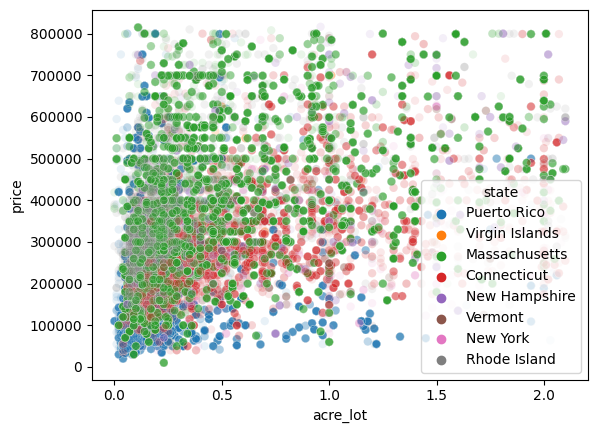

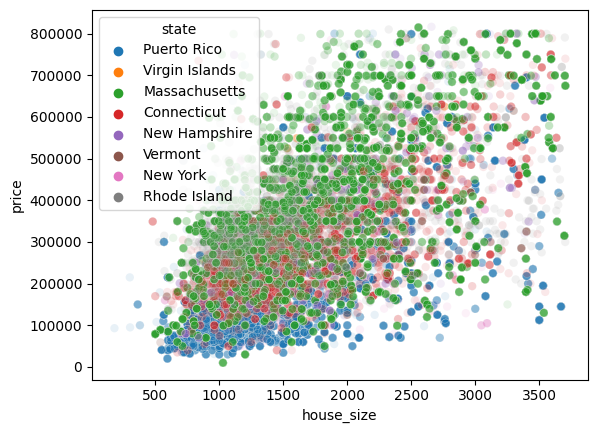

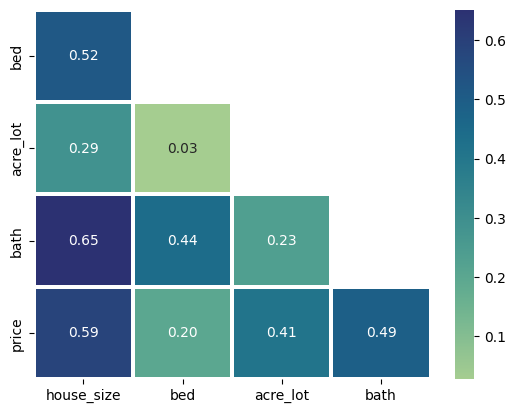

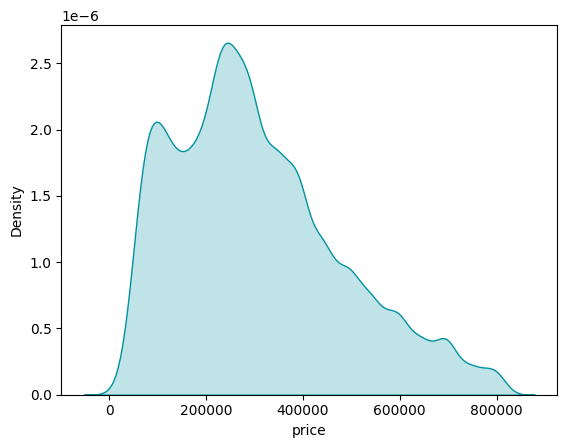

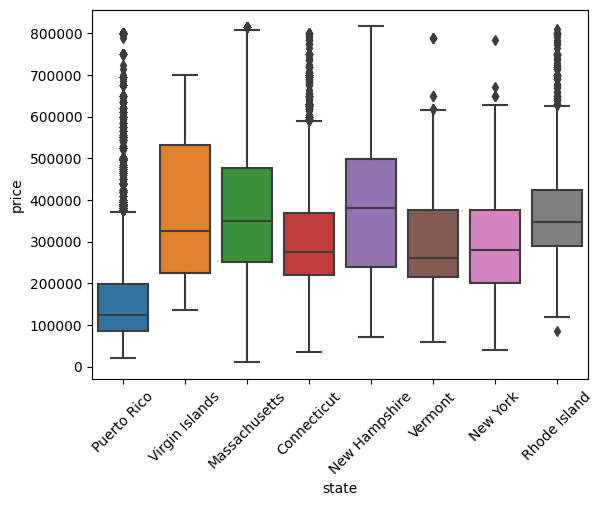

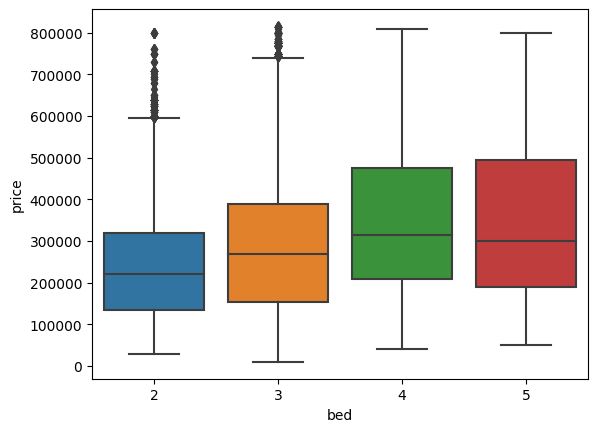

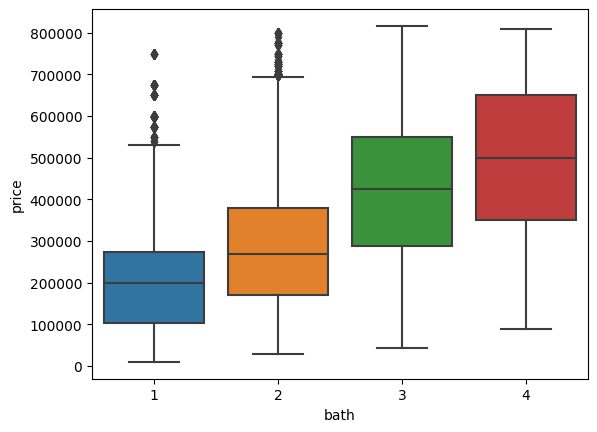

In [83]:
sns.scatterplot(df_dropna_all, x="acre_lot", y="price", hue="state", alpha=0.1)
plt.show()
sns.scatterplot(df_dropna_all, x="house_size", y="price", hue="state", alpha=0.1)
plt.show()
corr_mat = df_dropna_all[["house_size", "bed", "acre_lot", "bath", "price"]].corr()
mask = np.triu(np.ones_like(corr_mat)).astype(bool)
mask = mask[1:, :-1]
corr_mat = corr_mat.iloc[1:,:-1]
sns.heatmap(corr_mat, annot=True, linewidth=1.5, fmt=".2f", cmap="crest", mask=mask)
plt.show()
sns.kdeplot(df_dropna_all["price"], fill=True, color="#0092A0")
plt.show()
sns.boxplot(df_dropna_all, x="state", y="price")
plt.xticks(rotation=45)
plt.show()
sns.boxplot(df_dropna_all, x="bed", y="price")
plt.show()
sns.boxplot(df_dropna_all, x="bath", y="price")
plt.show()

Looks like number of bathrooms and house size have a correlation with the price which is an expected result

In [65]:
# Split features and labels
X_dropna_all = df_dropna_all.drop(columns=["price"])
y_dropna_all = df_dropna_all["price"].copy()

#### Models

First lets try only with numerical columns

In [75]:
X_dropna_all_num = df_dropna_all.select_dtypes(exclude=["object"])
X_train_dropna_all_num, X_test_dropna_all_num, y_train_dropna_all, y_test_dropna_all = train_test_split(X_dropna_all_num, y_dropna_all, test_size=0.2, random_state=47)

forest_reg = RandomForestRegressor(n_jobs=-1, random_state=47)
score = np.sqrt(-cross_val_score(forest_reg, X_train_dropna_all_num, y_train_dropna_all, scoring="neg_mean_squared_error", cv=5, n_jobs=-1))
print("Cross validation Mean squared error:", round(np.mean(score), 5))

CV Mean squared error: 76.77377


In [76]:
# Ridge regression
l2_reg = Ridge(random_state=47)
score = np.sqrt(-cross_val_score(l2_reg, X_train_dropna_all_num, y_train_dropna_all, scoring="neg_mean_squared_error", cv=5, n_jobs=-1))
print("Cross validation Mean squared error:", round(np.mean(score), 5))

Cross validation Mean squared error: 0.0


In [79]:
# Catboost
cat = CatBoostRegressor(random_state=47, verbose=0)
score = np.sqrt(-cross_val_score(cat, X_train_dropna_all_num, y_train_dropna_all, scoring="neg_mean_squared_error", cv=5, n_jobs=-1))
print("Cross validation Mean squared error:", round(np.mean(score), 5))

Cross validation Mean squared error: 1013.09572


Adding categorical columns

In [80]:
X_dropna_all_oh = pd.get_dummies(X_dropna_all)
X_train_dropna_all_oh, X_test_dropna_all_oh, y_train_dropna_oh, y_test_dropna_oh = train_test_split(X_dropna_all_oh, y_dropna_all, test_size=0.2, random_state=47)

forest_reg = RandomForestRegressor(n_jobs=-1, random_state=47)
score = np.sqrt(-cross_val_score(forest_reg, X_train_dropna_all_oh, y_train_dropna_oh, scoring="neg_mean_squared_error", cv=5, n_jobs=-1))
print("Cross validation Mean squared error:", round(np.mean(score), 5))

Cross validation Mean squared error: 29973.73078


In [81]:
# Ridge regression
l2_reg = Ridge(random_state=47)
score = np.sqrt(-cross_val_score(l2_reg, X_train_dropna_all_oh, y_train_dropna_oh, scoring="neg_mean_squared_error", cv=5, n_jobs=-1))
print("Cross validation Mean squared error:", round(np.mean(score), 5))

Cross validation Mean squared error: 88406.26816


From the above looks like state and city add a lot of noise and hurt performance a lot so it is better to use only the numerical features. Ridge regression was the best performing model.